In [38]:
import os
import re
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def calculate_pass_at_k_with_temporal_sampling(
    base_folder, 
    model_prefix=None, 
    base_model=None, 
    task_name=None, 
    max_t=8, 
    max_k=64,
):
    # Initialize list to store model folders with their steps
    model_folders = []
    

    for item in os.listdir(base_folder):
        item_path = os.path.join(base_folder, item)
        if os.path.isdir(item_path) and item.startswith(model_prefix):
            # Extract step number from folder name
            step_match = re.search(r'(?:step)_?(\d+)', item)
            if step_match:
                step_number = int(step_match.group(1))
                model_folders.append((step_number, item_path))
        
        # Add base model as step 0
        base_model_path = os.path.join(base_folder, base_model)
        if os.path.isdir(base_model_path):
            model_folders.append((0, base_model_path))
    
    # Sort by step number
    model_folders = sorted(model_folders, key=lambda x: x[0])
    
    
    # Store evaluation results for each problem at different steps
    problem_step_evaluations = defaultdict(lambda: defaultdict(list))
    # Track all encountered problem indices
    all_problem_indices = set()
    
    # Process each model folder
    for step_number, folder_path in model_folders:
        # Build result file path
        result_file = os.path.join(folder_path, f"model_final_answer_{task_name}.json")
        

        with open(result_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Process results for each problem
        for problem in data:
            problem_idx = problem.get("index", -1)
            
            if problem_idx >= 0:
                all_problem_indices.add(problem_idx)
                
                # Process all response results, treat null as 0 (incorrect)
                response_results = [
                    resp.get("llm_check_result", 0) == 1  
                    for resp in problem.get("responses", [])
                ]
                

                for evaluation_result in response_results:
                    problem_step_evaluations[problem_idx][step_number].append(evaluation_result)
    

    
    # Get all steps and sort them
    all_steps = sorted(list(set().union(*[d.keys() for d in problem_step_evaluations.values()])))
    
    

    # Build step sequence in descending order (newest to oldest)
    steps_descending = []
    for step in sorted(all_steps, reverse=True):
        steps_descending.append(step)
    


    
    # Print step sequence for debugging
    print(f"Step sequence: {steps_descending[:max_t]}")
    
    # Calculate cumulative pass@k for each t value
    pass_at_k_results = {}
    
    # Helper function: calculate combination number
    def combination(n, k):
        # Use standard library combination calculation function
        import math
        if k < 0 or k > n:
            return 0
        if k == 0 or k == n:
            return 1
        
        return math.comb(n, k)
    
    # Helper function: distribute samples across different steps
    def distribute_samples_across_steps(total_samples, num_steps):
        """
        Distribute total_samples across num_steps
        Strategy: distribute evenly, allocate remainder to earlier steps
        """
        base_allocation = total_samples // num_steps  # Base allocation per step
        remainder = total_samples % num_steps  # Remaining samples
        
        # Create distribution list
        sample_distribution = [base_allocation for _ in range(num_steps)]
        
        # Distribute remainder to first 'remainder' steps
        for i in range(remainder):
            sample_distribution[i] += 1
        
        return sample_distribution
    
    for t in range(1, min(len(steps_descending), max_t) + 1):
        selected_steps = steps_descending[:t]
        
        for m in range(1, max_k + 1):
            problem_pass_rates = []
            
            # Calculate for each problem separately
            for problem_idx in all_problem_indices:
                # Calculate how to distribute m samples across t models
                samples_per_step = distribute_samples_across_steps(m, t)  # e.g.: [2, 2, 2, 1] means 4 models sample 2,2,2,1 respectively
                
                # Calculate pass@m probability for each problem
                cumulative_fail_prob = 1.0  # Initialize failure probability
                
                # Iterate through each step and corresponding sample count
                for i, (step_num, num_samples) in enumerate(zip(selected_steps, samples_per_step)):
                    # Get evaluation results for this step
                    step_evaluations = problem_step_evaluations.get(problem_idx, {}).get(step_num, [])
                    
                    total_evaluations = len(step_evaluations)
                    correct_evaluations = sum(1 for result in step_evaluations if result)
                    
                    # Skip if no samples needed for this step
                    if num_samples == 0:
                        continue
                    
                    
                    # Calculate failure probability when sampling num_samples from this step
                    step_fail_prob = combination(total_evaluations - correct_evaluations, num_samples) / combination(total_evaluations, num_samples)
                    
                    # Multiply failure probabilities
                    cumulative_fail_prob *= step_fail_prob
                

                # Calculate success probability = 1 - failure probability
                problem_pass_rate = 1.0 - cumulative_fail_prob
                problem_pass_rates.append(problem_pass_rate)

            
            # Calculate average across all valid problems
            if problem_pass_rates:
                average_pass_rate = sum(problem_pass_rates) / len(problem_pass_rates) * 100
            else:
                average_pass_rate = 0
                print(f"Warning: No valid problems to calculate for t={t}, m={m} configuration")
            
            # Save results
            pass_at_k_results[(t, m)] = average_pass_rate
    
    return pass_at_k_results

In [39]:

base_folder = "../sampling_64_responses"
model_prefix = "UWNSL__Qwen2.5-7B-deepscaler_4k_step_"
base_model = "Qwen__Qwen2.5-7B"
task_name = "AIME"

# Calculate pass@k with temporal sampling
pass_at_k_with_temporal_sampling = calculate_pass_at_k_with_temporal_sampling(
    base_folder=base_folder,
    model_prefix=model_prefix,
    base_model=base_model,
    task_name=task_name,
    max_t=8,
    max_k=64
)




Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]


In [40]:
import json

output_file_path = 'exp_results/pass_at_k_results_AIME_Qwen2.5-7B_RL.json'
converted_dict = {f"{t}_{m}": value for (t, m), value in pass_at_k_with_temporal_sampling.items()}
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(converted_dict, f, indent=2)

print(f"Dictionary Saved in: {output_file_path}")

Dictionary Saved in: exp_results/pass_at_k_results_AIME_Qwen2.5-7B_RL.json


Chart saved as: exp_results/pass_at_k_results_AIME_Qwen2.5-7B_RL_plot.png


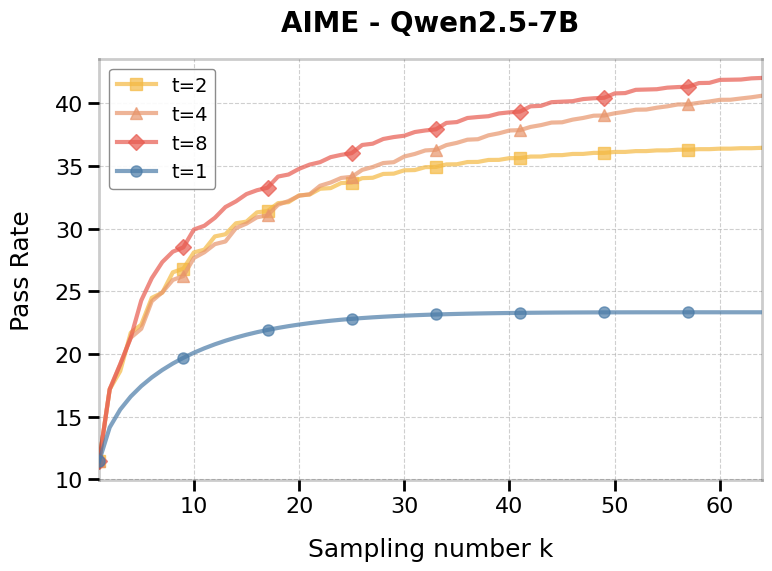

In [42]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_pass_at_k(filename, title=None, figsize=(8, 6)):
    """
    Plot Pass@k chart for a single data file
    
    Parameters:
    - filename: path to data file
    - title: chart title, auto-generated if None
    - figsize: chart dimensions
    """
    
    # Set clear and readable font configurations
    plt.rcParams.update({
        'font.size': 16,           
        'axes.titlesize': 20,      
        'axes.labelsize': 18,      
        'xtick.labelsize': 16,     
        'ytick.labelsize': 16,     
        'legend.fontsize': 14      
    })
    
    # Color and style configurations
    temporal_colors = {
        1: '#4A7BA7',    # Cool tone - dedicated for t=1 (fresh blue)
        2: '#F4B942',    # Warm tone - bright yellow
        4: '#E8956B',    # Warm tone - coral red
        8: '#E85A4F'     # Warm tone - warm orange
    }
    
    temporal_markers = {
        1: 'o',     # Circle - dedicated for t=1
        2: 's',     # Square
        4: '^',     # Triangle
        8: 'D'      # Diamond
    }
    
    temporal_linestyles = {
        1: '-',     # Solid line
        2: '-',     # Solid line
        4: '-',     # Solid line
        8: '-'      # Solid line
    }
    
    temporal_linewidths = {
        1: 3,       # t=1 thicker
        2: 3,
        4: 3,
        8: 3
    }
    
    temporal_markersizes = {
        1: 8,       # t=1 slightly larger
        2: 8,
        4: 8,
        8: 8
    }
    
    temporal_values = [1, 2, 4, 8]
    
    # Create chart
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    try:
        # Load data
        with open(filename, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
        
        # Restore tuple keys
        parsed_results = {tuple(map(int, key.split('_'))): value for key, value in raw_data.items()}
        
        # Get all available m values
        all_sampling_numbers = sorted(list(set(m for _, m in parsed_results.keys())))
        
        # First plot t=2,4,8 lines (background layer)
        for t in [2, 4, 8]:
            temporal_pass_rates = []
            for sampling_num in all_sampling_numbers:
                current_pass_rate = parsed_results.get((t, sampling_num), 0)
                temporal_pass_rates.append(current_pass_rate)
            
            # Adjust marker density based on data point count
            marker_frequency = 8 if len(all_sampling_numbers) <= 100 else 15
            
            ax.plot(all_sampling_numbers, temporal_pass_rates, 
                    label=f't={t}',
                    color=temporal_colors[t], 
                    marker=temporal_markers[t], 
                    markersize=temporal_markersizes[t],
                    linewidth=temporal_linewidths[t],    
                    linestyle=temporal_linestyles[t],
                    markevery=marker_frequency,
                    alpha=0.7)
        
        # Finally plot t=1 line (foreground layer, most prominent)
        t = 1
        temporal_pass_rates = []
        for sampling_num in all_sampling_numbers:
            current_pass_rate = parsed_results.get((t, sampling_num), 0)
            temporal_pass_rates.append(current_pass_rate)
        
        marker_frequency = 8 if len(all_sampling_numbers) <= 100 else 15
        
        ax.plot(all_sampling_numbers, temporal_pass_rates, 
                label=f't={t}',
                color=temporal_colors[t], 
                marker=temporal_markers[t], 
                markersize=temporal_markersizes[t],
                linewidth=temporal_linewidths[t],
                linestyle=temporal_linestyles[t],
                markevery=marker_frequency,
                alpha=0.7,
                zorder=10)  # Ensure it's in the foreground
        
        # Set chart properties
        if title is None:
            # Auto-generate title from filename
            title = filename.split('/')[-1].replace('.json', '').replace('_', ' ').title()
        
        ax.set_title(title, fontsize=20, pad=20, weight='bold')
        ax.set_xlabel('Sampling number k', fontsize=18, labelpad=15)
        ax.set_ylabel('Pass Rate', fontsize=18, labelpad=15)
        
        # Set grid and axes
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlim(1, max(all_sampling_numbers))
        
        # Set borders and ticks
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_alpha(0.2)
        
        ax.tick_params(width=2, length=8, labelsize=16)
        
        # Add legend
        ax.legend(fontsize=14, frameon=True, framealpha=0.9, edgecolor='gray')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save charts
        output_png_path = filename.replace('.json', '_plot.png')
        plt.savefig(output_png_path, dpi=150, bbox_inches='tight')
        plt.savefig(output_png_path.replace('.png', '.pdf'), bbox_inches='tight')
        
        print(f"Chart saved as: {output_png_path}")
        plt.show()
        
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error during plotting: {e}")

# Usage example
if __name__ == "__main__":
    # Plot chart for specified file
    plot_pass_at_k(
        'exp_results/pass_at_k_results_AIME_Qwen2.5-7B_RL.json',
        title='AIME - Qwen2.5-7B'
    )